# Algoritmos de optimización - Trabajo práctico<br>
Nombre y Apellidos: Gonzalo Blasco Ayuso<br>
Contacto 1: gonzalo.blasco96@gmail.com<br>
Contacto 2: gblascoa@student.universidadviu.com<br>
Url: https://github.com/gonblasco/MasterAIPublic.git<br>

### Problema
1. Sesiones de doblaje <br>

>Se precisa coordinar el doblaje de una película. Los actores del doblaje deben coincidir en las
>escenas en las que sus personajes aparecen juntos en las diferentes escenas. Los actores de
>doblaje cobran todos la misma cantidad por cada día que deben desplazarse hasta el estudio de
>grabación independientemente del número de escenas que se graben. No es posible grabar más
>de 6 escenas por día. El objetivo es planificar las sesiones por día de manera que el gasto por los
>servicios de los actores de doblaje sea el menor posible. Los datos son:
>- Número de actores: 10
>- Número de escenas: 30
>- Actores/escenas: https://bit.ly/36D8IuK
>   -  1 indica que el cator participa en la escena
>   -  0 en caso contrario

(*) La respuesta es obligatoria                                        

In [1]:
## LIBRERÍAS
import math
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### **(*)¿Cuántas posibilidades hay sin tener en cuenta las restricciones?**
### **¿Cuántas posibilidades hay teniendo en cuenta todas las restricciones?**

Sin tener en cuenta las restricciones, existen 2 opciones no aclaradas en el enunciado:

1. Cada día se tiene que aprovechar para rodar el máximo de tomas
- Sin tener en cuenta otras restricciones:
  - Una permutación de las 30 tomas, distribuidas en chunks de 6
$$
P(30) = 30!
$$

- Teniendo en cuenta las restricciones del enunciado (máximo 6 escenas por día)
  - Una permutación de las 30 tomas, distribuidas en chunks de 6
$$
P(30) = 30!
$$

In [2]:
# Calcular 30!
math.factorial(30)

265252859812191058636308480000000

2. Cada día no tiene un máximo de tomas, pero al menos se tiene que rodar una para que ese día cuente

- Sin tener en cuenta otras restricciones:
  - No se puede calcular sin saber el número máximo de escenas.

- Teniendo en cuenta las restricciones del enunciado (máximo 6 escenas por día):
  - Si se graba una escena por día nada más, se obtiene un máximo teórico de 30*6 = 180 posibilidades de grabar tomas, distribuidas en chunks de 6.
  - Son permutaciones con repetición para los huecos vacíos pero no para las tomas de 1 al 30.
$$
\binom{180}{30} = \frac{180!}{30! \times (180-30)!}
$$

In [3]:
# Cálculo del coeficiente binomial
n = 180  # Número total de elementos
k = 30   # Número de posiciones para los números del 1 al 30
# Calcular combinaciones
math.comb(n, k)

13256166154299679213044725041407792

Se ha optado por asumir la segunda opción. Por tanto, siempre hay una restricción implícita que es que se tiene que rodar al menos 1 toma por día. De lo contrario, ningún día sería de provecho en el estudio de doblaje y la película nunca se terminaría.

### **Modelo para el espacio de soluciones:**<br>
### **(*) ¿Cuál es la estructura de datos que mejor se adapta al problema? Arguméntalo.(Es posible que hayas elegido una al principio y veas la necesidad de cambiar, arguméntalo)**

Se ha optado por un array, un vector n elementos, para representar la solución. Cada índice del array representa un hueco para rodar una toma y el valor indica qué toma se rueda (número entre 1 y el 30) o un 0 en caso de que no se ruede una toma. El array se divide en *chunks* o subconjuntos del número máximo de tomas por día (6 en este problema).

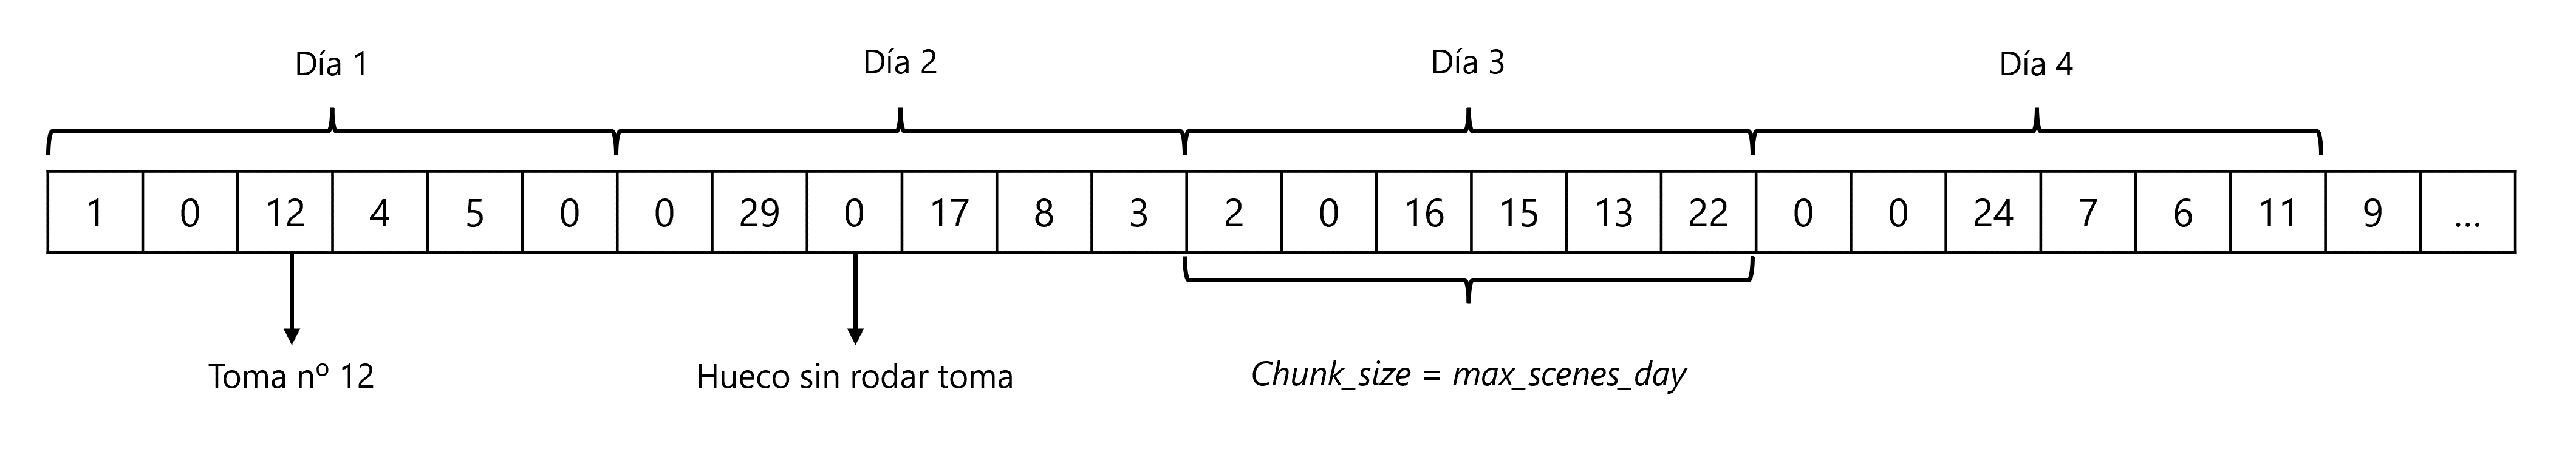

### **Según el modelo para el espacio de soluciones:**<br>
### **(*)¿Cual es la función objetivo?**
### **(*)¿Es un problema de maximización o minimización?**

La función objetivo es el coste medido con el número de desplazamientos necesario:

$$
f(S) = \sum_{d=1}^{D} \text{Desplazamientos}(d)
$$
que se calcula por cada día y después se suma para todos los dias utilizados en rodar las 30 escenas.

Se trata de un problema de **minimización**.

### **Diseña un algoritmo para resolver el problema por fuerza bruta.**

Se ha optado por un algoritmo de **búsqueda aleatoria**. Se prueban diferentes combinaciones en un total de n iteraciones y se escoge la mejor opción. Si el número de iteraciones es igual al número de combinaciones posible, se asegura alcanzar un mínimo global como solución.

Es un algoritmo ineficiente en para este problema.

In [4]:
## FUNCIONES AUXILIARES

# Generar una solución aleatoria
def gen_random_solution (total_scenes, max_scenes_day):

    # Todas las escenas en orden aleatorio, sin repeticiones y con posibles huecos vacíos
    # máximo de max_scenes_day escenas por día,
    # mínimo de 1 escena por día    
    # máximo teórico de max_scenes_day*total_scenes días
    theorical_max_days = total_scenes*max_scenes_day

    unique_scene_numbers = np.arange(1, total_scenes + 1)
    # 0 para indicar que no hay escena en ese hueco (máximo 5 huecos vacíos y 1 escena por día)
    zeros = np.zeros(theorical_max_days - len(unique_scene_numbers), dtype=int)
    # Juntar escenas con huecos vacíos
    solution = np.concatenate([unique_scene_numbers, zeros])
    # Orden aleatorio
    np.random.shuffle(solution)

    # No tiene sentido un día sin grabar ninguna escena
    # Así que mejor dividir en días y eliminar los días sin escenas
    days = [solution[i:i + max_scenes_day] for i in range(0, len(solution), max_scenes_day)]
    valid_days = [days for days in days if not np.all(days == 0)]

    # Generar la solución completa
    final_solution = np.concatenate(valid_days)

    return final_solution

# Mostrar la solución
def print_solution (solution, max_scenes_day):
    planning = [solution[i:i + max_scenes_day] for i in range(0, len(solution), max_scenes_day)]
    for i, scheduled_day in enumerate(planning):
        print(f"Día {i+1}: {['escena_' + str(x) for x in scheduled_day if x != 0]}")

# Gasto por día
def calc_expense_day (actors_scene_matrix, day):

    # Lista de actores requeridos para ese día
    required_actors = []

    for scene in day:
        # Obtener los actores que participan en la escena
        scene_metadata = actors_scene_matrix[scene-1]
        included_actors = [i+1 for i, value in enumerate(scene_metadata) if value == 1]
        
        # Incluir actores a la lista de actores para ese día, si no se encontraban ya
        required_actors.extend([element for element in included_actors if element not in required_actors])

    return len(required_actors)

# Gasto total por solución
def calc_expense_solution (actors_scene_matrix, solution, max_scenes_day):
    # solution: list[]
    # Lista con la configuración de las escenas por día

    accumulated_expense = 0
    # Cada max_scenes_day se divide el array para obtener un día, usando slicing
    for day in [solution[i:i + max_scenes_day] for i in range(0, len(solution), max_scenes_day)]:
        # calcular gasto por día
        accumulated_expense += calc_expense_day(actors_scene_matrix, day)

    return accumulated_expense

# Solución con menor gasto (igual no la necesito!!!!)
def get_min_expense_solution (actors_scene_matrix, solution_set, max_scenes_day):
    # solution_set: list[list[]]

    best_solution = []
    best_expense = 99999999 # Número grande

    for solution in solution_set:
        expense = calc_expense_solution(actors_scene_matrix, solution, max_scenes_day)
        if expense < best_expense:
            best_solution = solution
            best_expense = expense
    
    return best_solution

In [5]:
## BÚSQUEDA ALEATORIA

def random_search (actors_scene_matrix, total_scenes, max_scenes_day, n):
    # n: número de iteraciones

    best_solution = []
    best_expense = 10e100  # Número grande

    for i in range(n):
        solution = gen_random_solution(total_scenes, max_scenes_day)
        expense = calc_expense_solution(actors_scene_matrix, solution, max_scenes_day)

        if expense < best_expense:
            best_solution = solution
            best_expense = expense

    return best_solution, best_expense

### **Calcula la complejidad del algoritmo por fuerza bruta.**

El orden de complejidad del algoritmo es lineal para una iteración, y crece de forma lineal en el tiempo.
$$
O(n \times \text{{total\_scenes}} \times \text{{max\_scenes\_day}} \times \text{{total\_actors}})
$$
$$
O(n)
$$

### **(*)Diseña un algoritmo que mejore la complejidad del algortimo por fuerza bruta. Argumenta porque crees que mejora el algoritmo por fuerza bruta.**

Utilizando la metaheurística del **Simulated Annealing** se ha desarollado un algoritmo más eficiente para encontrar la solución.<br>
La función de probabilidad utilizada:
$$
P_{\text{aceptación}} = \exp\left(-\frac{\delta}{T}\right)
$$
La función de descenso de temperatura escogida es la del descenso exponencial:
$$
T_{k+1} = \alpha \cdot T_k
$$

In [6]:
## SIMULATED ANNEALING

# Generar una solución vecina
def gen_neighboring_solution (solution, max_scenes_day):
    
   # Índices te todos los elementos
    indices = np.arange(len(solution))
    
    # Seleccionar aleatoriamente 2 índices (toma o cero)
    i, j = np.random.choice(indices, size=2, replace=False)
    
    # Intercambiar elementos
    solution[i], solution[j] = solution[j], solution[i]

    # No tiene sentido un día sin grabar ninguna escena
    # Así que mejor dividir en días y eliminar los días sin escenas
    days = [solution[i:i + max_scenes_day] for i in range(0, len(solution), max_scenes_day)]
    valid_days = [days for days in days if not np.all(days == 0)]

    return np.concatenate(valid_days)


# Función de probabilidad para aceptar peores soluciones
def accept(T, d):
  if np.random.rand() < math.exp(-1 * d / T):
    return True
  else:
    return False

# Función de descenso de temperatura
# Probando a bajar la temperatura más lentamente me da una mejores soluciones
def cool_down(T):
  return T * 0.999

def s_a(actors_scene_matrix, total_scenes, max_scenes_day, T):

  # Para análisis
  iterations = []
  temperatures = []
  expenses = []

  ref_solution = gen_random_solution(total_scenes, max_scenes_day)
  ref_expense = calc_expense_solution(actors_scene_matrix, ref_solution, max_scenes_day)

  best_solution = []
  best_expense = 10e100  # número grande

  n = 0
  while T > .0001: # hasta que se enfríe
    n += 1

    # Generar una solución vecina
    current_solution = gen_neighboring_solution(ref_solution, max_scenes_day)
    current_expense = calc_expense_solution(actors_scene_matrix, current_solution, max_scenes_day)

    # Si es la mejor solución de todas -> guardar
    if current_expense < best_expense:
        best_solution = current_solution
        best_expense = current_expense

    # Si la nueva vecina es mejor se cambia
    # Si es peor se cambia según una probabilidad que depende de T y delta (ref_expense - current_expense)
    if current_expense < ref_expense or accept(T, abs(ref_expense - current_expense)):
      ref_solution = copy.deepcopy(current_solution)
      ref_expense = current_expense

    # Bajamos la temperatura
    T = cool_down(T)

    # Almacenar datos para análisis
    iterations.append(n)
    temperatures.append(T)
    expenses.append(best_expense)

  return best_solution, best_expense, iterations, temperatures, expenses

### **(*)Calcula la complejidad del algoritmo**

El orden de complejidad del algoritmo es lineal para una iteración, y crece de forma lineal en el tiempo.
$$
O(n \times \text{{total\_scenes}} \times \text{{max\_scenes\_day}} \times \text{{total\_actors}})
$$
$$
O(n)
$$

### **Según el problema (y tenga sentido), diseña un juego de datos de entrada aleatorios.**

Los datos de entrada no son aleatorios, provienen del enunciado.

In [7]:
## DATOS DEL PROBLEMA

# Tabla actores por escena
# El índice de fila m+1 es el número identificativo de la escena
# El índice de columna n+1 es el número identificativo del actor
actors_scene_matrix = np.array([
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
])

# Test
# Total de escenas por actor
column_totals = actors_scene_matrix.sum(axis = 0)
print(f"Comprobación: total de escenas por actor {column_totals}")
# Total de actores por escena
row_totals = actors_scene_matrix.sum(axis = 1)
print(f"Comprobación: total de actores por escena {row_totals}")

Comprobación: total de escenas por actor [22 14 13 15 11  8  3  4  2  2]
Comprobación: total de actores por escena [5 3 3 4 3 4 4 3 3 4 5 5 3 3 3 2 2 2 2 4 2 4 2 2 4 4 2 2 3 2]


### **Aplica el algoritmo al juego de datos generado.**

Se ejecutan dos *tests* para comprobar la mejora con el nuevo algoritmo que utiliza heurísticas para obtener una mejor solución.<br>
Conclusiones:
- La búsqueda aleatoria aporta soluciones poco óptimas.
- El Simulated Annealing depende mucho de la función de generación de solución vecina.
  - Se intercambian escenas de posición.
  - Se eliminan los días vacíos para compactar los rodajes y ceñirse al propósito del problema.

In [8]:
## TEST: BÚSQUEDA ALEATORIA
solution_1, solution_expense_1 = random_search(actors_scene_matrix, total_scenes=30, max_scenes_day=6, n=10000)
print("BÚSQUEDA ALEATORIA")
print("Mejor solución:")
print_solution(solution_1, 6)
print(f"Gasto total (# desplazamientos) : {solution_expense_1}")

BÚSQUEDA ALEATORIA
Mejor solución:
Día 1: ['escena_1', 'escena_19', 'escena_26']
Día 2: ['escena_9', 'escena_25']
Día 3: ['escena_2']
Día 4: ['escena_15', 'escena_22']
Día 5: ['escena_3', 'escena_6']
Día 6: ['escena_23', 'escena_18']
Día 7: ['escena_14', 'escena_16', 'escena_28']
Día 8: ['escena_30']
Día 9: ['escena_4', 'escena_20']
Día 10: ['escena_12', 'escena_27', 'escena_8', 'escena_11']
Día 11: ['escena_10']
Día 12: ['escena_7']
Día 13: ['escena_17', 'escena_24']
Día 14: ['escena_29', 'escena_21', 'escena_13']
Día 15: ['escena_5']
Gasto total (# desplazamientos) : 71


Mejor solución:
Día 1: ['escena_7', 'escena_22', 'escena_9', 'escena_25', 'escena_2']
Día 2: ['escena_27', 'escena_26', 'escena_30', 'escena_17', 'escena_15', 'escena_6']
Día 3: ['escena_23', 'escena_10', 'escena_18', 'escena_4', 'escena_24', 'escena_8']
Día 4: ['escena_1', 'escena_19', 'escena_12', 'escena_14', 'escena_3', 'escena_28']
Día 5: ['escena_16']
Día 6: ['escena_5', 'escena_20', 'escena_29', 'escena_11', 'escena_13', 'escena_21']
Gasto total (# desplazamientos) : 37


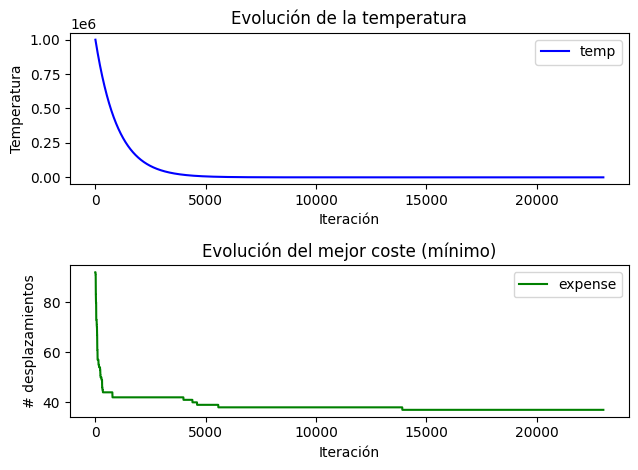

In [9]:
## TEST: SIMULATED ANNEALING
solution_2, solution_expense_2, x_iterations, y_temperatures, y_expenses = s_a(actors_scene_matrix, total_scenes=30, max_scenes_day=6, T=1000000)
print("Mejor solución:")
print_solution(solution_2, 6)
print(f"Gasto total (# desplazamientos) : {solution_expense_2}")

# Análisis
f, ax = plt.subplots(2,1)

ax[0].plot(x_iterations, y_temperatures, 'b', label='temp')
ax[0].legend()
ax[0].set_title('Evolución de la temperatura')
ax[0].set_xlabel('Iteración')
ax[0].set_ylabel('Temperatura')
ax[1].plot(x_iterations, y_expenses, 'g', label='expense')
ax[1].legend()
ax[1].set_title('Evolución del mejor coste (mínimo)')
ax[1].set_xlabel('Iteración')
ax[1].set_ylabel('# desplazamientos')

plt.tight_layout()
plt.show()

### **Enumera las referencias que has utilizado (si ha sido necesario) para llevar a cabo el trabajo.**

[1] MathWorks, "How Simulated Annealing Works," MATLAB & Simulink, 2023. [Online]. Available: https://es.mathworks.com/help/gads/how-simulated-annealing-works.html. [Accessed: 27-Sep-2024].<br>
[2] J. Alvarez and M. Simo, *Comprehensive Simulated Annealing*, 2008. [Online]. Available: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://mat.uab.cat/~alseda/MasterOpt/ComprehensiveSimulatedAnnealing.pdf. [Accessed: 27-Sep-2024].

### **Describe brevemente las lineas de como crees que es posible avanzar en el estudio del problema. Ten en cuenta incluso posibles variaciones del problema y/o variaciones al alza del tamaño.**

- Diferente función de generación del vecino puede llevar a menor tiempo en alcanzar soluciones más óptimas.
  - Reversión del array
  - Eliminación de huecos vacíos o tomas

- Con otras metaheurísticas se pueden alcanzar soluciones en menor tiempo
  - Búsqueda tabú -> se puede combinar con Simulated Annealing

- Finalmente s epueden jugar con los parámetros para llegar a soluciones más óptimas:
  - Menor ratio de descenso de temperatura -> diversificar más al principìo